 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

Notebook to combine actual Fraser River data with monthly climatologies for all the other rivers.

Steps to Create this Notebook:
* create daily files containing climatology for all rivers : done
* figure out how the Hope data compares to the climatology for the Fraser Drainage from Morrison : done
* replace Fraser information in the daily files with combined Hope/climatology data

### Now updated to work with a daily climatology

In [1]:
import arrow
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml

#from salishsea_tools import nc_tools
from salishsea_tools import rivertools
from salishsea_tools import river_201702

%matplotlib inline

In [2]:
# Constant and data ranges etc
year = 2017
smonth = 1
emonth = 12
startdate = arrow.get(year, smonth, 1)
enddate = arrow.get(year, emonth, 31)
print (startdate, enddate)

2017-01-01T00:00:00+00:00 2017-12-31T00:00:00+00:00


In [3]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = pd.read_csv(filename, names=['year', 'month', 'day', 'flow'], sep='\s+')
fraserflow.insert(0, 'datetime', pd.to_datetime(fraserflow[['year', 'month', 'day']], utc=True))
fraserflow = fraserflow.set_index('datetime')
fraserflow = fraserflow.drop(['year', 'month', 'day'], axis=1)
print (fraserflow[fraserflow.index == startdate.datetime] )

                               flow
datetime                           
2017-01-01 00:00:00+00:00  1261.699


Fraser River at Hope Seasonal Climatology (found in matlab using Mark's mean daily data)  
climFraseratHope = (931, 878, 866, 1814, 4097, 6970, 5538, 3539, 2372, 1937, 1595, 1119)  
and then smoothed using SeasonalCyclesFromMonthlyMeans

(366,)
(365,)


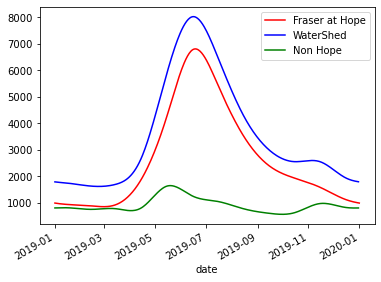

In [4]:
climFraseratHope = xr.open_dataset('FraserAtHope_daily_climatology.nc') ['fraser at hope']
print(climFraseratHope.shape)
# Climatology, Fraser Watershed
fluxfile = xr.open_dataset('~/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

climFraserWaterShed = fluxfile['fraser']
print(climFraserWaterShed.shape)
NonHope = climFraserWaterShed - climFraseratHope
climFraseratHope.plot(color='r', label="Fraser at Hope")
climFraserWaterShed.plot(color='b',label="WaterShed")
NonHope.plot(color='g',label="Non Hope");
plt.legend();

In [5]:
# 
fraserratio = river_201702.prop_dict['fraser']['Fraser']['prop']
print (fraserratio)
print (climFraserWaterShed.sum())
print (NonHope.sum())
print ('Fraser at Hope ratio', NonHope.sum()/climFraserWaterShed.sum())

otherratio = 1 - fraserratio

nonFraser = otherratio * climFraserWaterShed.sum()/NonHope.sum() * NonHope
afterHope = NonHope - nonFraser

FraserClimatologySeparation = {"Ratio that is not Fraser": otherratio,
                               "Ratio that is Fraser": fraserratio,
                               "non Fraser by Day": np.array(nonFraser[:]).tolist(),
                               "after Hope by Day": np.array(afterHope[:]).tolist()}
# write to file for us to use in production
with open('FraserDailyClimatologySeparation.yaml', 'wt') as f:
    yaml.safe_dump(FraserClimatologySeparation, f)

0.984
<xarray.DataArray 'fraser' ()>
array(1294746., dtype=float32)
<xarray.DataArray ()>
array(329101.92720008)
Fraser at Hope ratio <xarray.DataArray ()>
array(0.25418262)


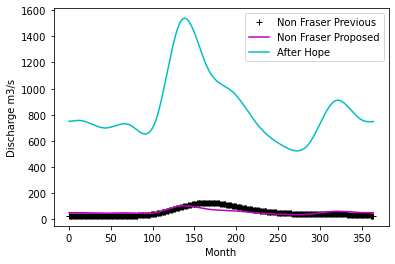

In [6]:
plt.plot(climFraserWaterShed*otherratio,'k+',label="Non Fraser Previous")
plt.plot(nonFraser,'m',label="Non Fraser Proposed")
plt.plot(afterHope,'c',label="After Hope")
plt.legend()
plt.xlabel('Month')
plt.ylabel('Discharge m3/s')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Discharge m3/s');

In [7]:
def fraser_correction(pd, fraserflux, afterHope, NonFraser, fraserratio, otherratio,
                      runoff, area):
    ''' for the Fraser Basin only, replace basic values with the new climatology after Hope and the
     observed values for Hope.  Note, we are changing runoff only and not using/changing river
     depth '''
    for key in pd:
        if "Fraser" in key:
            flux = afterHope + fraserflux
            subarea = fraserratio
        else:
            flux = NonFraser
            subarea = otherratio
        
        river = pd[key]
        runoff = rivertools.fill_runoff_array(flux*river['prop']/subarea, river['i'],
                          river['di'], river['j'], river['dj'], river['depth'], runoff, 
                          np.zeros_like(runoff), area)[0]
    return runoff


In [ ]:
climatology.close()

In [8]:
climatology = xr.open_dataset('rivers_daily_201702.nc')
flows_2015 = climatology.copy(deep=True)
propd = river_201702.prop_dict['fraser']
print (flows_2015)

<xarray.Dataset>
Dimensions:       (time_counter: 366, x: 398, y: 898)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
    area          (y, x) float64 ...
    rorunoff      (time_counter, y, x) float64 ...
    rodepth       (time_counter, y, x) float64 ...
    rotemper      (time_counter, y, x) float64 ...
Attributes:
    acknowledgements:      Based on Morrison et al climatology and Allen and ...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...

In [9]:
print(afterHope.values.shape)


(365,)


In [10]:
for day in arrow.Arrow.range('day', startdate, enddate):
    print (day.format('DDD'))
    yearday = int(day.format('DDD')) - 1
    driverflow = climatology.rorunoff.values[yearday]
    frasertoday = fraserflow[fraserflow.index == day.datetime].flow
    if yearday == 365:
        runoff = fraser_correction(propd, frasertoday.values[0], afterHope.values[yearday-1],
                                  nonFraser[yearday-1], fraserratio, otherratio, driverflow,
                                  climatology.area.values[:])
    else:
        runoff = fraser_correction(propd, frasertoday.values[0], afterHope.values[yearday], 
                               nonFraser[yearday], fraserratio,
                              otherratio, driverflow, climatology.area.values[:])
    flows_2015.rorunoff[yearday] = runoff

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


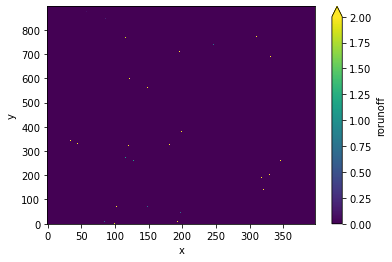

In [11]:
flows_2015.rorunoff[0:31].sum(axis=0).plot(vmax=2);

In [12]:
climatology.close()
climatology = xr.open_dataset('rivers_daily_201702.nc')

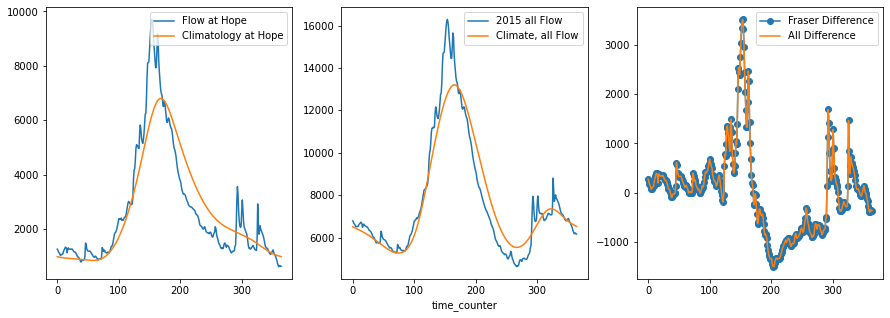

In [13]:
iend = 365; leapyear=False
if leapyear == True:
    lenddate = arrow.get(year, emonth, 30)
else:
    lenddate = enddate
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(fraserflow[startdate.datetime:enddate.datetime].flow.values, label='Flow at Hope')

(flows_2015.area * flows_2015.rorunoff[0:iend]/1000.).sum(axis=0).sum(axis=0).plot(ax=axs[1], label='2015 all Flow');
(climatology.area * climatology.rorunoff[0:iend]/1000.).sum(axis=0).sum(axis=0).plot(ax=axs[1], label='Climate, all Flow')
axs[0].plot(fluxfile.fraser[0:iend].values - afterHope[0:iend] - nonFraser[0:iend], label="Climatology at Hope");
axs[2].plot(fraserflow[startdate.datetime:lenddate.datetime].flow.values -
           (fluxfile.fraser[0:iend].values - afterHope[0:iend] - nonFraser[0:iend]), 'o-', label="Fraser Difference");
axs[2].plot(((flows_2015.area * flows_2015.rorunoff[0:iend] - 
              climatology.area * climatology.rorunoff[0:iend]
            )/1000).sum(axis=0).sum(axis=0), label="All Difference");
for ax in axs:
    ax.legend()

In [ ]:
(climatology.area*climatology.rorunoff[0:31])

In [ ]:
flows_2015

In [20]:
print (flows_2015.rodepth.max())

<xarray.DataArray 'rodepth' ()>
array(3.)


In [ ]:
for i in range(898):
    for j in range(398):
        if flows_2015.rorunoff[0, i, j] != 0:
            if flows_2015.rotemper[0, i, j] == 0:
                print (i, j)

In [14]:
def write_file(startdate, enddate, flows_2015):
    "keep it small and simple, runoff only"
    notebook = 'RealFraserClimateElse.ipynb'
    coords = {
        'x' : flows_2015.x.values,
        'y' : flows_2015.y.values,
        'time_counter' : [0],
    }
    var_attrs = {'units': 'kg m-2 s-1',
                      'long_name': 'runoff_flux'}
    for day in arrow.Arrow.range('day', startdate, enddate):
        time_counter = int(day.format('DDD')) - 1
        year = day.year
        month = day.month
        day = day.day
        # set up filename to follow NEMO conventions
        filename = f'ncfiles/R202012DFraCElse_y{year}m{month:02}d{day:02}.nc'
        print (filename)
        
        netcdf_title = f'Rivers for y{year}m{month:02}d{day:02}'
        ds_attrs = {
        'acknowledgements':
            'Based on Morrison et al climatology and ECCC Fraser at Hope',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'Salish Sea MEOPAR Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
        'title': netcdf_title,
        'notebook': notebook,
        'summary': f'Daily Runoff',
        'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
        }

        da = xr.DataArray(
            data = flows_2015.rorunoff.values[time_counter:time_counter+1],
            name='rorunoff',
            dims=('time_counter', 'y', 'x'),
            coords = coords,
            attrs = var_attrs)
    

        ds = xr.Dataset(
            data_vars={
            'rorunoff': da},
            coords = coords,
            attrs = ds_attrs
        )
    
        encoding = {var: {'zlib': True} for var in ds.data_vars}

        ds.to_netcdf(filename, unlimited_dims=('time_counter'),
            encoding=encoding,)


In [15]:
write_file(startdate, enddate, flows_2015)

ncfiles/R202012DFraCElse_y2017m01d01.nc
ncfiles/R202012DFraCElse_y2017m01d02.nc
ncfiles/R202012DFraCElse_y2017m01d03.nc
ncfiles/R202012DFraCElse_y2017m01d04.nc
ncfiles/R202012DFraCElse_y2017m01d05.nc
ncfiles/R202012DFraCElse_y2017m01d06.nc
ncfiles/R202012DFraCElse_y2017m01d07.nc
ncfiles/R202012DFraCElse_y2017m01d08.nc
ncfiles/R202012DFraCElse_y2017m01d09.nc
ncfiles/R202012DFraCElse_y2017m01d10.nc
ncfiles/R202012DFraCElse_y2017m01d11.nc
ncfiles/R202012DFraCElse_y2017m01d12.nc
ncfiles/R202012DFraCElse_y2017m01d13.nc
ncfiles/R202012DFraCElse_y2017m01d14.nc
ncfiles/R202012DFraCElse_y2017m01d15.nc
ncfiles/R202012DFraCElse_y2017m01d16.nc
ncfiles/R202012DFraCElse_y2017m01d17.nc
ncfiles/R202012DFraCElse_y2017m01d18.nc
ncfiles/R202012DFraCElse_y2017m01d19.nc
ncfiles/R202012DFraCElse_y2017m01d20.nc
ncfiles/R202012DFraCElse_y2017m01d21.nc
ncfiles/R202012DFraCElse_y2017m01d22.nc
ncfiles/R202012DFraCElse_y2017m01d23.nc
ncfiles/R202012DFraCElse_y2017m01d24.nc
ncfiles/R202012DFraCElse_y2017m01d25.nc


In [16]:
testfile = xr.open_dataset('ncfiles/R202012DFraCElse_y2017m05d21.nc')

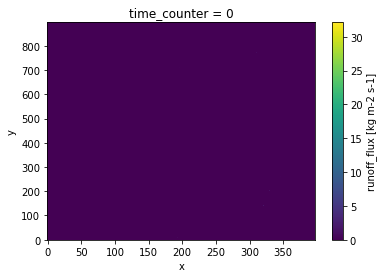

In [17]:
testfile.rorunoff.plot();

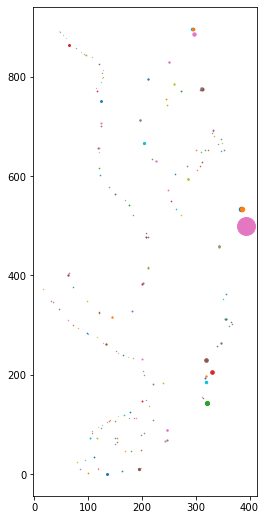

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
for i in range(898):
    for j in range(398):
        flux = testfile.rorunoff[0, i, j]
        if flux > 0 :
            plt.scatter(j, i, s=flux*10)

In [21]:
origfile = xr.open_dataset('/results/forcing/rivers/R201702DFraCElse_y2017m05d21.nc')

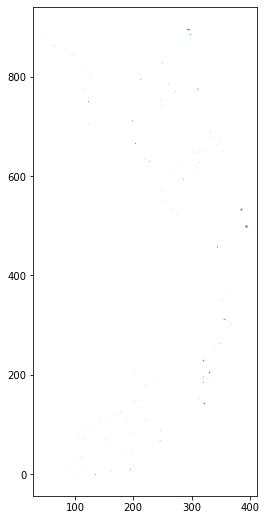

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
for i in range(898):
    for j in range(398):
        flux = testfile.rorunoff[0, i, j] - origfile.rorunoff[0, i, j]
        if flux > 0 :
            plt.scatter(j, i, s=flux*10)

In [23]:
testfile.close()
origfile.close()

In [ ]:
testfile = xr.open_dataset('ncfiles/R202012DFraCElse_y2015.nc')
origfile = xr.open_dataset('ncfiles/R201702DFraCElse_y2015.nc')
oldfile = xr.open_dataset('ncfiles/RFraserCElse_y2015.nc')

In [ ]:
testfile.rorunoff[15, 500, 394]

In [ ]:
daily2020 = testfile.rorunoff[:].sum(axis=1).sum(axis=1) - testfile.rorunoff[:, 500, 394]

In [ ]:
daily2017 = origfile.rorunoff[:].sum(axis=1).sum(axis=1) - origfile.rorunoff[:, 500, 394]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
for i in range(380, 445):
    for j in range(280, 398):
        flux = oldfile.rorunoff[15, i, j]
        if flux > 0 :
            flux = flux - origfile.rorunoff[15, i ,j]
            plt.scatter(j, i, s=flux*10)
            print (i, j, flux)

In [ ]:
daily_old = oldfile.rorunoff[:].sum(axis=1).sum(axis=1) - oldfile.rorunoff[:, 380:445, 280:398].sum(axis=1).sum(axis=1)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(daily2020.values);
ax.plot(daily2017.values);
ax.plot(daily_old.values);

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(daily2020.values - daily2017.values);

In [24]:
4732560+2160*365

5520960